# Plastic Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/surfriderfoundationeurope/IA_Pau/blob/master/Hackaton_Surfrider_Getting_Started.ipynb)


The goal is to build a plastic classifier, as the core detector / tracker is already built (but only works for generic plastic).

If you want fast training, make sure you have a good GPU: check using the command `!nvidia-smi`

Please install the required packages:   
`pip install -r requirements.txt`

### Getting the data

To get the images of [taco](http://tacodataset.org/) project, you download the dataset from [here](https://www.kaggle.com/kneroma/tacotrashdataset).        
Then put the `data` content folder in the `data/images/` folder of this repository, to have this structure:
- `data/images/images-taco/`
    - `bach_1/`
    - `bach_2/`
    - `bach_3/`
    - ...
    - `annotations.json`
    - `meta_df.csv`

In [1]:
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import cv2

In [2]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential

# Constants

In [3]:
images_folder = '../../data/images/images-taco/'
annotationFile = images_folder + 'meta_df.csv'
annotationFileTrain = images_folder + 'meta_df_train.csv'
annotationFileTest = images_folder + 'meta_df_test.csv'

# Pre-processing

## 1 - Load images

In [4]:
dataset = pd.read_csv(annotationFile)
len(dataset)

4784

In [ ]:
data = dataset.iloc[0]

# 1 - load data
img = cv2.imread(images_folder + data['img_file'])
plt.imshow(img)

## Split train / test datasets

In [ ]:
train_ratio=0.8
with open(annotationFile, 'r') as f:
    lines = f.readlines()
    header = lines[0]
    lines = lines[1:]
    random.shuffle(lines)
    train_size = int(len(lines) * train_ratio)
    train_lines = lines[:train_size]
    test_lines = lines[train_size:]
    with open(annotationFileTrain, 'w') as f_train:
        f_train.write(header)
        f_train.writelines(train_lines)
    with open(annotationFileTest, 'w') as f_test:
        f_test.write(header)
        f_test.writelines(test_lines)

# Analyse the dataset

the next following cells enable you to get a bit of information about the dataset

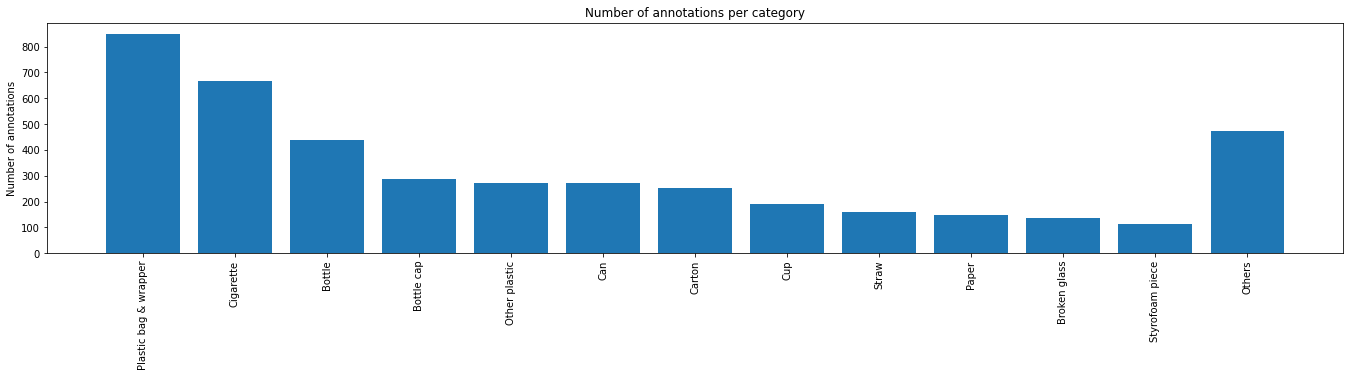

In [6]:
categories = dataset['supercategory'][[value != 'Unlabeled litter' for value in dataset['supercategory']]]
categories_count = categories.value_counts()
# remove images with less than 100 annotations
other_count = sum(categories_count[categories_count < 100].values)
# add other category to categories_count
categories_count['Others'] = other_count
categories_count = categories_count[ [value > 100 for value in categories_count.values] ]

# get categories names and how many images are in each category


classes = categories_count.index
nbr_images = categories_count.values

plt.bar(x = classes, height =nbr_images)
plt.xticks(range(len(classes)), classes, rotation='vertical')
plt.ylabel('Number of annotations')
plt.tight_layout()
plt.autoscale(True)
plt.title('Number of annotations per category')
# set full width
plt.subplots_adjust(left=0.0, right=3.0, top=0.9, bottom=0.1)
# plt.savefig('dataset_analysis')
plt.show()

In [7]:
nbr_class = len(classes)
print('Number of classes:', nbr_class)
print('Number of images:', sum(nbr_images))

Number of classes: 13
Number of images: 4267


# Remake the dataset

In [8]:
# # remove spaces from category names
# cat_names_folders = [cat.replace(' ', '_').replace('&', 'and') for cat in cat_names]
# for cat in cat_names_folders:
#     # verify if folder exists
#     if not os.path.exists(images_folder + cat):
#         os.makedirs(images_folder + cat)

# if not os.path.exists(images_folder + 'Others'):
#         os.makedirs(images_folder + 'Others')

In [9]:
# img_size = (200, 200)

# annotations = pd.read_csv(annotationFile)

# image_file_nbr = 0

# # parcour annotations
# for index, annotation in annotations.iterrows():
#     if annotation["supercategory"] != 'Unlabeled litter':
#         image = cv2.imread(images_folder + annotation["img_file"])
#         # resize image to good size
#         image = cv2.resize(image, img_size)
#         # convert to RGB
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # save image
#         image_file_name = str(image_file_nbr) + '.' + annotation["img_file"].split(".")[1]
#         cat_name_folder = annotation["supercategory"].replace(' ', '_').replace('&', 'and')
#         if cat_name_folder not in cat_names_folders:
#             cat_name_folder = 'Others'
#         cv2.imwrite(images_folder + cat_name_folder + '/' + image_file_name, image)
#         image_file_nbr += 1

In [10]:
# # remove folders batch*
# for folder in os.listdir(images_folder):
#     if folder.startswith('batch'):
#         for file in os.listdir(images_folder + folder):
#             os.remove(images_folder + folder + '/' + file)
#         os.rmdir(images_folder + folder)

In [11]:
import glob

# List all images in the images folder that have JPG or jpg extension
img_list = glob.glob(os.path.join(images_folder, '*/*'))
len(img_list)

4267

In [12]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.2,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.2)

train_generator=train.flow_from_directory(images_folder,
                                          target_size=(200,200),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(images_folder,
                                        target_size=(200,200),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 3420 images belonging to 13 classes.
Found 847 images belonging to 13 classes.
{'Bottle': 0, 'Bottle_cap': 1, 'Broken_glass': 2, 'Can': 3, 'Carton': 4, 'Cigarette': 5, 'Cup': 6, 'Other_plastic': 7, 'Others': 8, 'Paper': 9, 'Plastic_bag_and_wrapper': 10, 'Straw': 11, 'Styrofoam_piece': 12}
{0: 'Bottle', 1: 'Bottle_cap', 2: 'Broken_glass', 3: 'Can', 4: 'Carton', 5: 'Cigarette', 6: 'Cup', 7: 'Other_plastic', 8: 'Others', 9: 'Paper', 10: 'Plastic_bag_and_wrapper', 11: 'Straw', 12: 'Styrofoam_piece'}


# Building CNN & Saving keras model

In [13]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(200,200,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(nbr_class,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

2022-01-30 11:03:23.587930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 11:03:23.619376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sylvain/.pyenv/versions/3.8.9/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.6/lib64:
2022-01-30 11:03:23.619388: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-30 11:03:23.619676: I tensorfl

# Compile model

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Training

In [15]:
history = model.fit_generator(train_generator,
                              epochs=60,
                              steps_per_epoch=3413//32,
                              validation_data=test_generator,
                              validation_steps=853//32,
                              workers = 4,
                              callbacks=callbacks_list)

/tmp/ipykernel_86331/1666181094.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/60
106/106 [==============================] - ETA: 0s - loss: 2.4661 - acc: 0.1756
Epoch 00001: val_acc improved from -inf to 0.19712, saving model to trained_model.h5
106/106 [==============================] - 43s 398ms/step - loss: 2.4661 - acc: 0.1756 - val_loss: 2.4182 - val_acc: 0.1971
Epoch 2/60
106/106 [==============================] - ETA: 0s - loss: 2.4194 - acc: 0.1874
Epoch 00002: val_acc improved from 0.19712 to 0.19952, saving model to trained_model.h5
106/106 [==============================] - 41s 387ms/step - loss: 2.4194 - acc: 0.1874 - val_loss: 2.3929 - val_acc: 0.1995
Epoch 3/60
106/106 [==============================] - ETA: 0s - loss: 2.4016 - acc: 0.1907
Epoch 00003: val_acc improved from 0.19952 to 0.20433, saving model to trained_model.h5
106/106 [==============================] - 40s 380ms/step - loss: 2.4016 - acc: 0.1907 - val_loss: 2.4646 - val_acc: 0.2043
Epoch 4/60
106/106 [==============================] - ETA: 0s - loss: 2.3997 - acc: 0.1936
Epo

# Testing

Maximum Probability:  0.19125964
Classified: Plastic_bag_and_wrapper


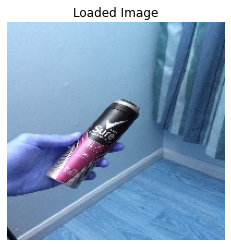

In [21]:
from keras.preprocessing import image

img_path = images_folder + 'Can/' + '67.jpg'

img = image.load_img(img_path, target_size=(200, 200))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

BOTTLE : 9.84 %
BOTTLE_CAP : 7.07 %
BROKEN_GLASS : 1.26 %
CAN : 8.88 %
CARTON : 8.5 %
CIGARETTE : 6.17 %
CUP : 6.33 %
OTHER_PLASTIC : 4.13 %
OTHERS : 15.29 %
PAPER : 5.4 %
PLASTIC_BAG_AND_WRAPPER : 19.13 %
STRAW : 4.37 %
STYROFOAM_PIECE : 3.64 %


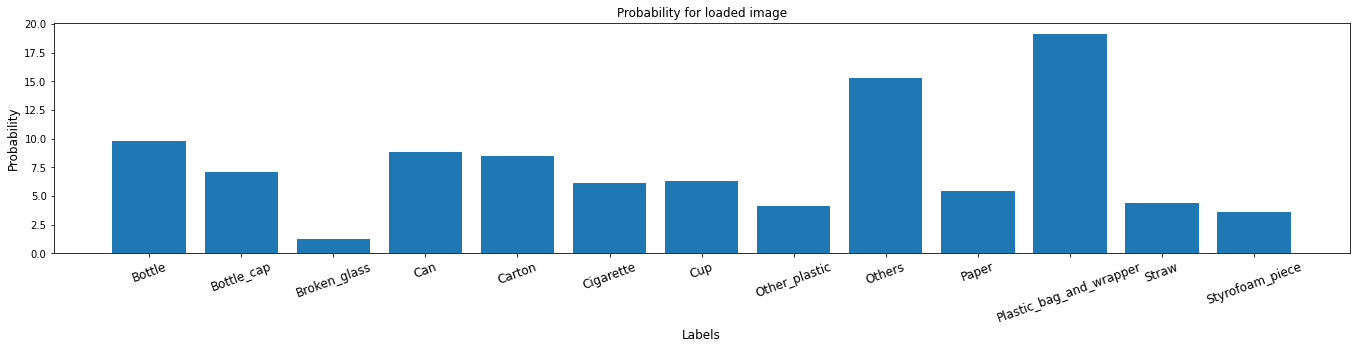

In [41]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.subplots_adjust(left=0.0, right=3.0, top=0.9, bottom=0.1)
    plt.show()
plot_bar_x()

In [67]:
# trace a confusion matrix
from sklearn.metrics import confusion_matrix
y_true = train_generator.classes
y_pred = model.predict_generator(train_generator, steps=3424//32)
y_pred = np.argmax(y_pred, axis=-1)
confusion_matrix = confusion_matrix(y_true, y_pred)

/tmp/ipykernel_86331/2836684234.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(train_generator, steps=3424//32)


In [70]:
# plot confusion matrix in a table format
confusion_matrix

array([[  5,   1,   7,   2,   4,  95,   0,   5,  28,   0, 205,   0,   0],
       [  3,   0,   5,   3,   0,  72,   0,   1,  30,   0, 118,   0,   0],
       [  6,   1,   3,   2,   2,  27,   0,   2,   9,   0,  59,   0,   0],
       [  3,   1,   6,   1,   6,  56,   0,   6,  22,   0, 118,   0,   0],
       [  2,   0,   4,   3,   4,  45,   0,   1,  19,   0, 123,   0,   0],
       [ 15,   2,  19,   3,   7, 138,   0,   9,  48,   0, 293,   0,   0],
       [  3,   1,   4,   3,   1,  41,   0,   2,  14,   0,  85,   0,   0],
       [  7,   1,   2,   0,   1,  53,   0,   4,  20,   0, 131,   0,   0],
       [  9,   1,   4,   4,   5, 116,   0,   7,  26,   0, 208,   0,   0],
       [  3,   0,   4,   3,   3,  36,   0,   3,   9,   0,  58,   0,   0],
       [ 16,   0,  21,   6,   8, 177,   0,  12,  53,   0, 387,   0,   0],
       [  4,   0,   6,   2,   3,  27,   0,   1,  12,   0,  74,   0,   0],
       [  3,   1,   1,   2,   2,  18,   0,   3,   7,   0,  53,   0,   0]])

# Accuracy Graph

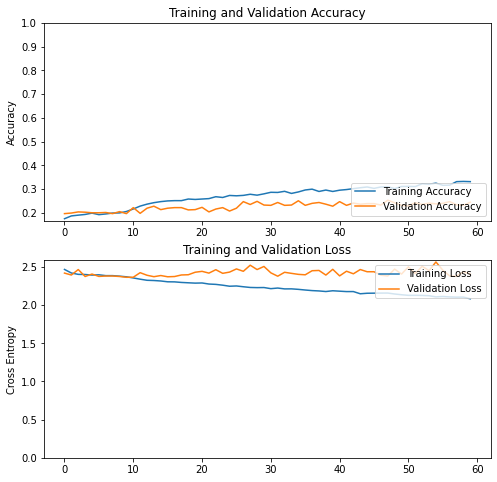

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy graph
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Loss graph
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()